# Bank Note Verification
### By Taro Iyadomi  

Here we will be doing all of the analysis and modeling for the bank note data. Full documentation can be found in this [github repository](https://github.com/taroii/bank_note_verification).

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [10]:
bank = pd.read_csv('bank_note_data.csv')

### I. EDA

In [11]:
bank.describe()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


C:\Users\Polar\AppData\Local\Temp\ipykernel_22100\3815331754.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  p = bank.boxplot(by='Class', return_type='axes', ax=axes, patch_artist=True, notch=True)


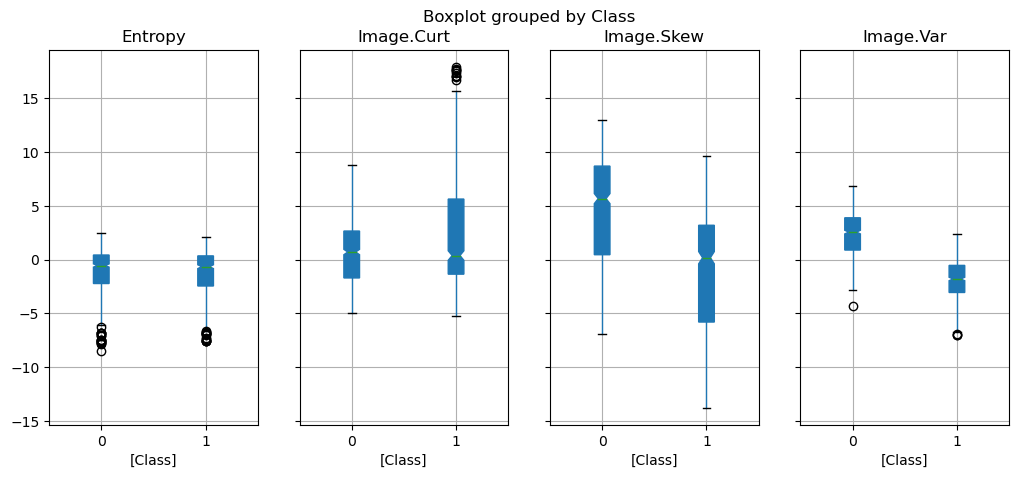

In [12]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 5), sharey=True)
p = bank.boxplot(by='Class', return_type='axes', ax=axes, patch_artist=True, notch=True)


In the graphic above, we can see that the variables Entropy and Image.Curt have the most outliers, whereas the variables Image.Skew and Image.Var have relatively fewer outliers. 

<AxesSubplot: xlabel='Class', ylabel='count'>

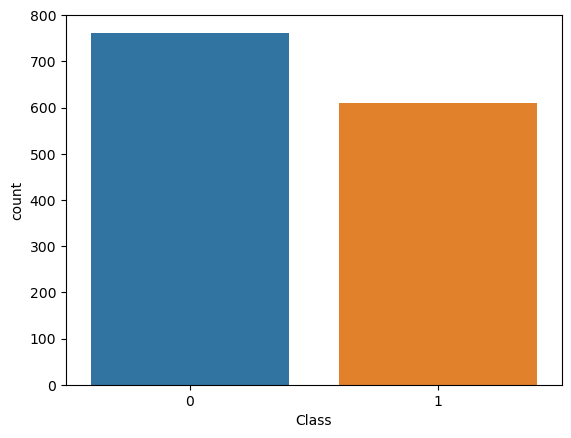

In [13]:
sns.countplot(x="Class", data=bank)

Here we can see that this is a pretty balanced dataset, with 44% of the observations being fake (class == 0) and the rest being real (class == 1).  

In [14]:
bank.isnull().sum()

Image.Var     0
Image.Skew    0
Image.Curt    0
Entropy       0
Class         0
dtype: int64

Since there are no missing values, we will not have to do any imputation!

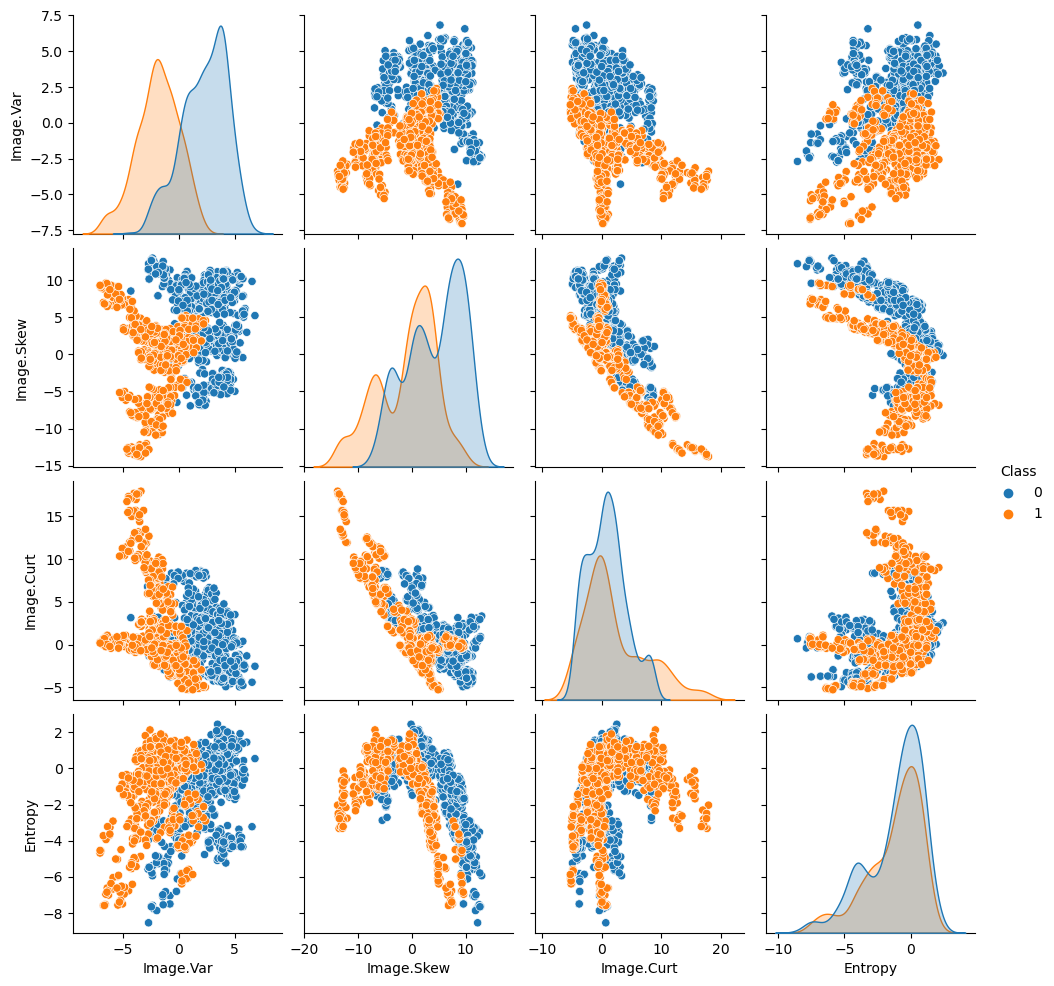

In [15]:
sns.pairplot(bank, hue="Class")

Here, we see some separation of class between image.var and image.skew in their density plots (diagonal), meaning that these predictors will be better able to differentiate between real and fake bank notes. On the otherhand, image.Curt and entropy show a lot of overlap, indicating that it may be harder to use these predictors to distinguish between real and fake.

In [16]:
bank.corr()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
Image.Var,1.000000,0.264026,-0.380850,0.276817,-0.724843
Image.Skew,0.264026,1.000000,-0.786895,-0.526321,-0.444688
Image.Curt,-0.380850,-0.786895,1.000000,0.318841,0.155883
Entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
Class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


<AxesSubplot: >

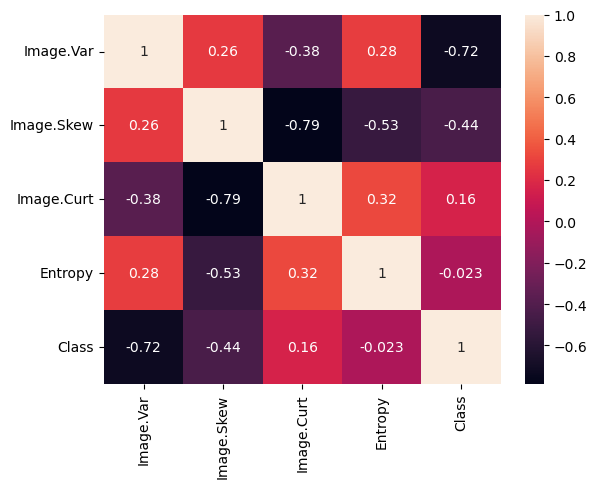

In [17]:
sns.heatmap(bank.corr(), annot=True)

Again, we see higher correlations between image.var/image.skew and class, with higher variance and skew leading to a higher chance of the bank note being fake. We also see that image.curt and entropy have little to do with the class, with much lower correlations. In terms of collinearity, image.skew and image.curt are very related with a correlation of -0.787, and image.skew and entropy are also correlated with a correlation of -0.526. 

### II. Data Processing

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
predictors = bank.columns[0:4]

X_train, X_test, y_train, y_test = train_test_split(bank[predictors], bank.Class, train_size = 0.8)

In [19]:
print(X_train.shape,
y_train.shape,
X_test.shape,
y_test.shape)

(1097, 4) (1097,) (275, 4) (275,)


### III. Model Building

Gradient boosting is a popular machine learning algorithm for both regression and classification tasks. The algorithm involves sequentially training a series of weak decision trees, with each new tree attempting to correct the errors of the previous tree. The predictions of the individual trees are combined through a weighted sum to produce a final prediction. The weights are determined by minimizing a loss function, such as mean squared error or, in our case, log loss, through gradient descent. The result is a powerful ensemble model that can achieve high accuracy on a variety of tasks.

For example, imagine you have a big problem like predicting whether a customer will buy a product or not. To solve this problem, you can create many small rules (or decision trees) that predict the outcome based on different factors, like age, gender, and income. Each rule by itself might not be very accurate, but by combining them together in a clever way, you can create a much more accurate prediction. Gradient boosting is a way to combine these small rules and improve them over time to make even better predictions.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)
y_hat = xgb.predict(X_test)

In [30]:
# Accuracy
xgb_accuracy = xgb.score(X_test, y_test)
print(f'The accuracy of the XGBoost classifier is: {xgb_accuracy}')

The accuracy of the XGBoost classifier is: 0.9927272727272727


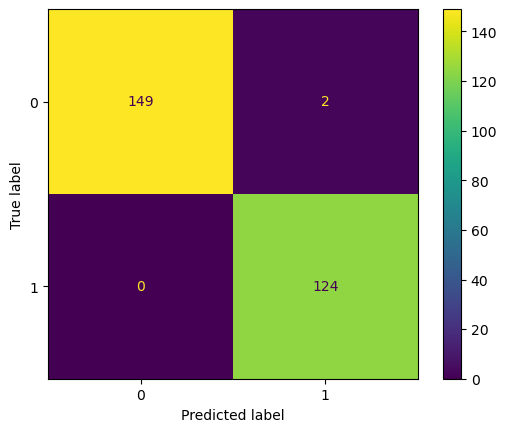

In [23]:
cm = confusion_matrix(y_test, y_hat)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

In [31]:
# Precision
from sklearn.metrics import precision_score
xgb_precision = precision_score(y_test, y_hat)
print(xgb_precision)

0.9841269841269841


In the context of bank note validity, we want to try our best to minimize false positives as false positives allow fake bills to circulate through the economy. 

#### Further Models

Although the 2023 DS intern specification indicated that we'll only use XGBoost for this training course, I can run some quick comparisons using logistic regression, knn, and random forests.  

The accuracy of the logistic regression model is: 0.9890909090909091
The precision of the logistic regression model is: 0.9763779527559056


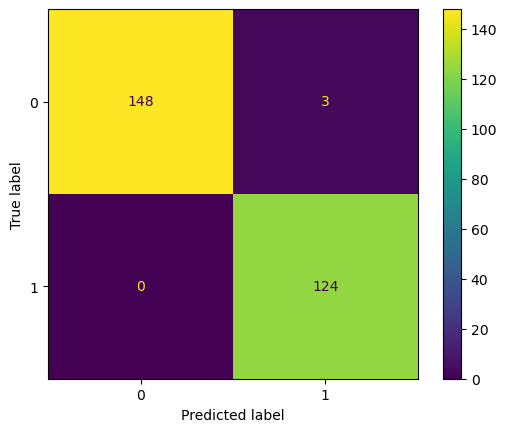

In [28]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_hat_logistic = logistic_model.predict(X_test)

#Accuracy
logistic_acc = logistic_model.score(X_test, y_test)
print(f'The accuracy of the logistic regression model is: {logistic_acc}')

#Precision
logistic_precision = precision_score(y_test, y_hat_logistic)
print(f'The precision of the logistic regression model is: {logistic_precision}')

#Confusion Matrix
cm = confusion_matrix(y_test, y_hat_logistic)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

The accuracy of the knn model is: 1.0
The precision of the knn model is: 1.0


c:\Users\Polar\Anaconda3\envs\minimal\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\Polar\Anaconda3\envs\minimal\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

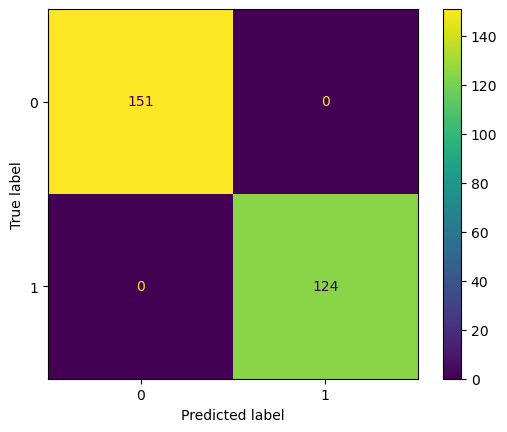

In [27]:
#kNN Classifier with n=5
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_hat_knn = knn_model.predict(X_test)

#Accuracy
knn_acc = knn_model.score(X_test, y_test)
print(f'The accuracy of the knn model is: {knn_acc}')

#Precision
knn_precision = precision_score(y_test, y_hat_knn)
print(f'The precision of the knn model is: {knn_precision}')

#Confusion Matrix
cm = confusion_matrix(y_test, y_hat_knn)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

The accuracy of the Random Forest model is: 0.9927272727272727
The precision of the Random Forest model is: 0.9841269841269841


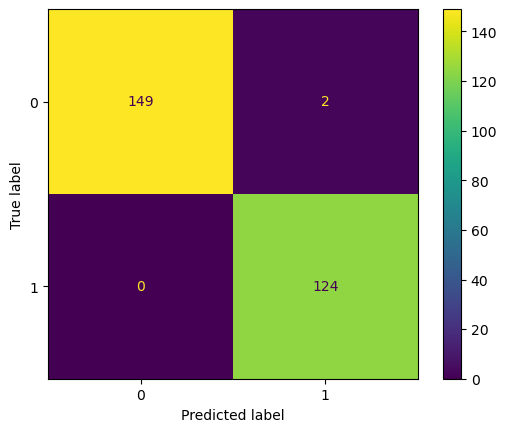

In [29]:
# Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_hat_rf = rf_model.predict(X_test)

#Accuracy
rf_acc = rf_model.score(X_test, y_test)
print(f'The accuracy of the Random Forest model is: {rf_acc}')

#Precision
rf_precision = precision_score(y_test, y_hat_rf)
print(f'The precision of the Random Forest model is: {rf_precision}')

#Confusion Matrix
cm = confusion_matrix(y_test, y_hat_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()

#### Choosing Best Model

Now that we've tried multiple classification algorithms, we can choose the best model based on accuracy and precision.

(0.9, 1.0)

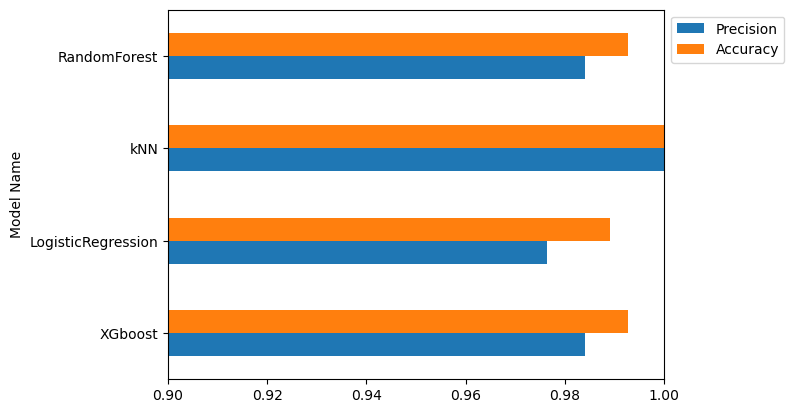

In [50]:
model_specs = pd.DataFrame({
    'Model Name':['XGboost', 'LogisticRegression', 'kNN', 'RandomForest'],
    'Accuracy':[xgb_accuracy, logistic_acc, knn_acc, rf_acc],
    'Precision':[xgb_precision, logistic_precision, knn_precision, rf_precision],
})

model_specs.plot(x='Model Name', y=['Precision', 'Accuracy'], kind='barh').legend(bbox_to_anchor=(1.0, 1))
plt.xlim(0.9, 1)
#plt.legend(loc='upper left')

In [115]:
fig = go.Figure([
    go.Bar(name = 'Precision', x=model_specs['Model Name'], y=model_specs['Precision']),
    go.Bar(name='Accuracy', x=model_specs['Model Name'], y=model_specs['Accuracy'])
])
fig.update_layout(yaxis_range = [0.95, 1], template='plotly_white')
fig.show()

fig.write_html('model_specs.html')

As we can see, kNN outperformed the three other models with a perfect accuracy and precision. While this difference may be insignificant (due to random chance), all four of the models have a very high accuracy and precision, meaning that they are all pretty good options. Another benefit of kNN is its ease of explainability, and since we have a relatively small dataset to work on, we don't have to worry about efficiency issues. One thing we can take advantage of from the random forest model, however, is that it measures the importance of each feature in the dataset. Just like we implied in the EDA, we can see below that the importance of Image.Skew and Image.Var are higher than Image.Curt and Entropy, meaning that the variance and skew of bank note images play a bigger role in determining the validity of the bank note. 

In [120]:
importances = rf_model.feature_importances_
names = rf_model.feature_names_in_

fig = px.bar(y = names, x = importances, orientation='h', template='plotly_white')
fig.write_html('importances.html')